In [1]:
!pip install lifelines
!pip install plotly==4.14.3
!pip install chart_studio

     |████████████████████████████████| 348kB 8.1MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=fba9fe87727dc476bacd4a7addb65cb1092a4eb1c8142694d44b5c9b22905436
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma
     |████████████████████████████████| 13.2MB 332kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 71kB 4.6MB/s 


### IMPORTAR LIBRERIAS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import cufflinks as cf
pd.options.plotting.backend = 'plotly'
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### FUNCIONES

Función para corrplot

In [229]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
          corr['x'], corr['y'],
          color=corr['value'], color_range=[-1, 1],
          palette=sns.diverging_palette(20, 220, n=256),
          size=corr['value'].abs(), size_range=[0,1],
          marker=marker,
          x_order=data.columns,
          y_order=data.columns[::-1],
          size_scale=size_scale
      )

In [230]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [231]:
test = pd.read_csv('/content/drive/MyDrive/1. IRONHACK/BBDD/Copia de test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [232]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1459.0,2190.000000,421.321334,1461.0,1825.50,2190.0,2554.50,2919.0
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0


In [233]:
train = pd.read_csv('/content/drive/MyDrive/1. IRONHACK/BBDD/Copia de train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [234]:
train.shape
#1460 ids (casas), 81 variables

(1460, 81)

In [235]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [236]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [237]:
#correlation matrix
#Pearson correlation: measures linear correlation
train_corr = train.corr()
train_corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

In [238]:
#Identify the relationship between SalesPrice and all the other variables
train_corr.sort_values('SalePrice', ascending=False)['SalePrice']
#Vamos a identificar las 10 variables que más afectan al precio de venta

#con esto podemos ver que la variable que más afecta al precio es OverallQual, seguido de GrLivArea: Superficie habitable sobre el nivel (suelo) pies cuadrados

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [239]:
#columnas que solo son numéricas para la matriz de correlación con colores
df_numeric = train.select_dtypes(include = 'int64')
df_numeric

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [240]:
df_numeric_columns = df_numeric.columns
df_numeric_columns

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

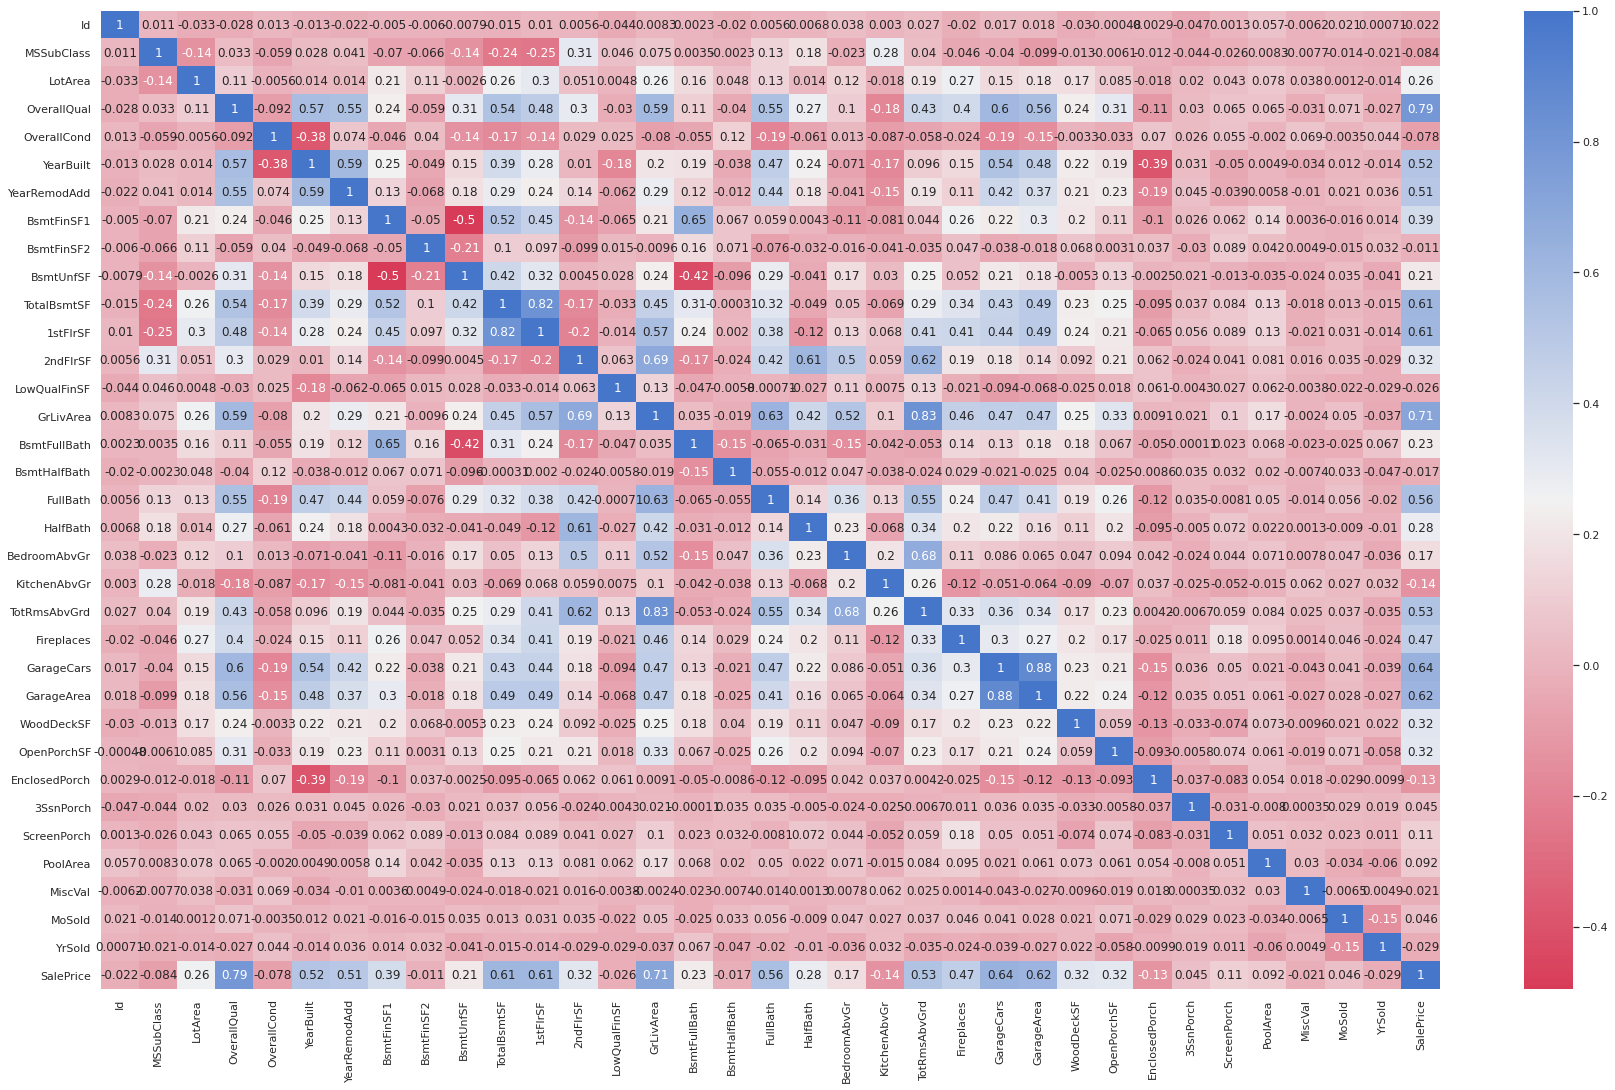

In [241]:
#matriz de correlación con colores
#asignar tamaño de grafica
#plt.subplots(figsize = (25,15))
sns.set(rc={'figure.figsize':(30,18)})
colores_corr_train = train[df_numeric_columns].corr()
cmap = sns.diverging_palette(6,255,as_cmap=True)
sns.heatmap(colores_corr_train, cmap=cmap, annot=True)
#mas rojo, correlación negativa

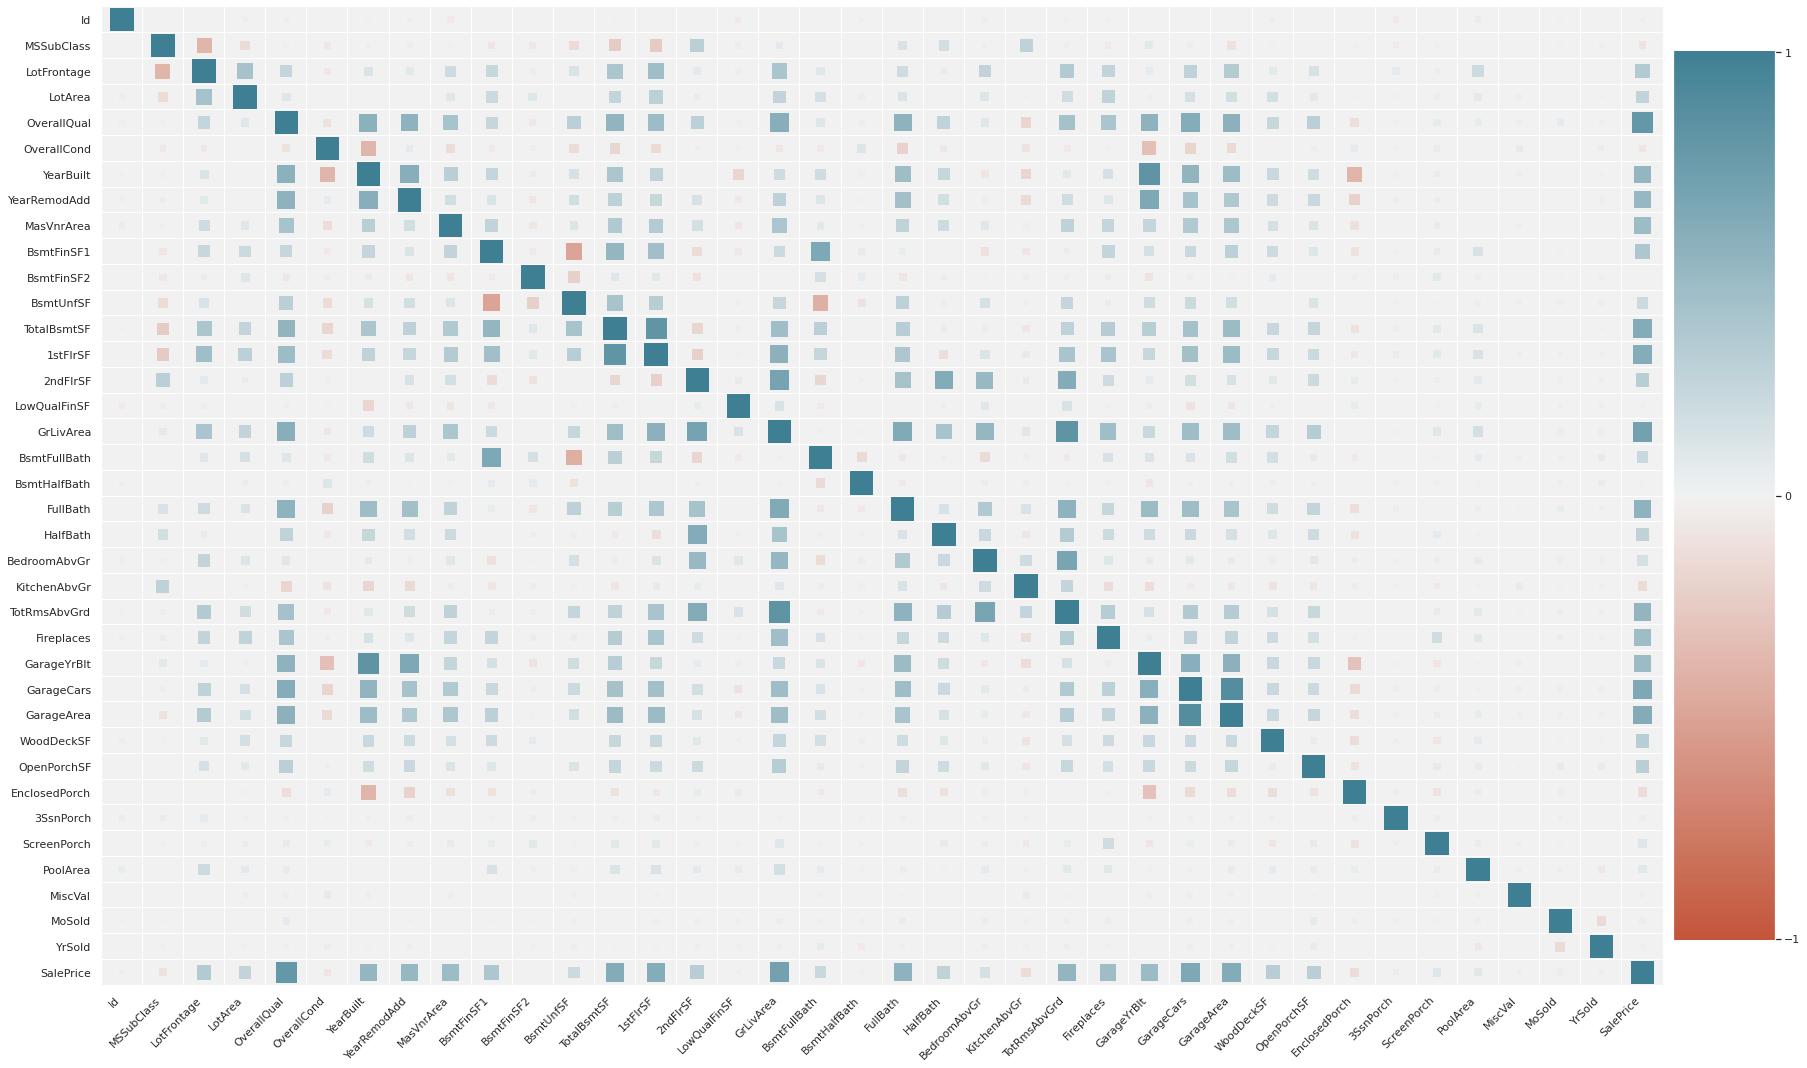

In [242]:
corrplot(train.corr())

In [243]:
#sns.pairplot(df_numeric_train, hue='up_down_median_price', kind='reg')

In [244]:
#Si un agente quisiera empezar a vender propiedes, cuál es el vecindario que en promedio es más caro? (tendrá mayor comisión)
sell_neighborhood = train.groupby('Neighborhood').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending=False).reset_index()
sell_neighborhood

,Neighborhood,SalePrice
0,NoRidge,335295.317073
1,NridgHt,316270.623377
2,StoneBr,310499.000000
3,Timber,242247.447368
4,Veenker,238772.727273
5,Somerst,225379.837209
6,ClearCr,212565.428571
7,Crawfor,210624.725490
8,CollgCr,197965.773333
9,Blmngtn,194870.882353


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

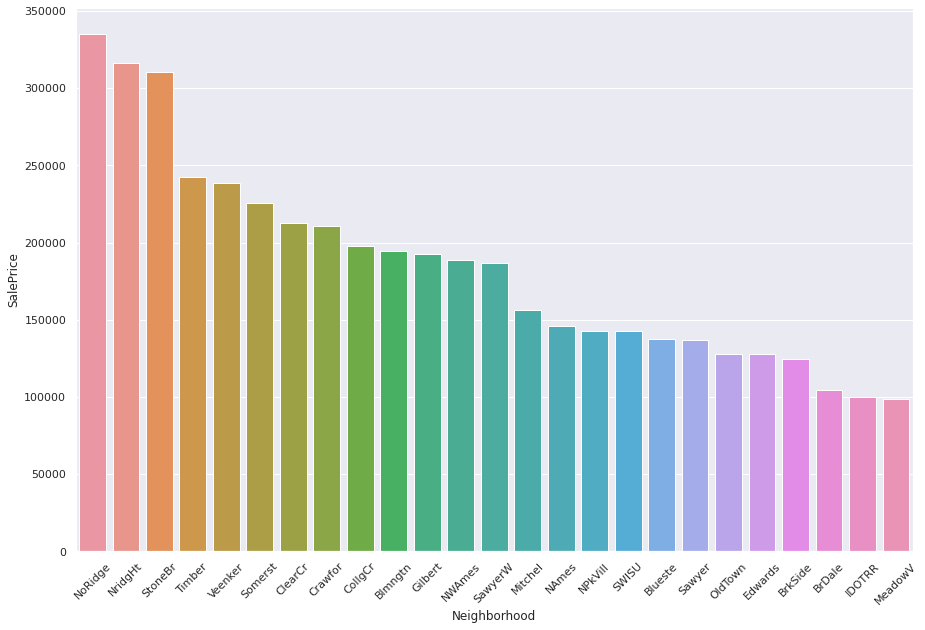

In [245]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="Neighborhood", y="SalePrice", data=sell_neighborhood)
plt.xticks(rotation=45)

In [246]:
#Using the `crosstab` function, find the neighborhood that has the most general qualities
# Your code here:
crosstab = pd.crosstab(train['Neighborhood'], train['OverallQual']).sort_values(10,ascending=False)
crosstab

OverallQual,1,2,3,4,5,6,7,8,9,10
Neighborhood,,,,,,,,,,
NridgHt,0,0,0,0,0,2,16,27,24,8
NoRidge,0,0,0,0,0,0,12,24,1,4
Edwards,1,0,5,25,38,23,5,0,1,2
OldTown,0,0,6,17,47,22,16,3,0,2
StoneBr,0,0,0,0,0,0,3,16,5,1
Somerst,0,0,0,0,0,11,41,29,4,1
Blmngtn,0,0,0,0,0,0,14,3,0,0
NPkVill,0,0,0,0,0,9,0,0,0,0
Timber,0,0,0,0,5,6,8,16,3,0


## Vamos a comprobar si las siguientes variables no numéricas influyen en el precio de venta:
El vecindario se cruzó con todas las variables

- Utilities = AllPub (incluidos todos los servicios públicos)
-  Condition1 = Artery (que la casa se encuentra adyacente a una avenida principal)
- BsmtCond = Condición general del Sótano
- GarageQual = Calidad general del Garage

In [247]:
#vamos a hacer un DF solamente con Veenker para evaluar su relación con las variables de interes
#df_veenker = train[train['Neighborhood'] == 'Veenker']
#df_veenker.sort_values('SalePrice', ascending=False)

In [248]:
train = train[train['GarageQual'].isnull() == False ]

In [249]:
model_amb = ols("SalePrice ~ C(train['Neighborhood'])+ C(train['Utilities'] == 'AllPub') + (C(train['Neighborhood']) * C(train['Utilities'] == 'AllPub'))", data=train).fit()
sm.stats.anova_lm(model_amb, typ=2)
# Este ANOVA nos da de conclusión que si influye el vecindario (Neighborhood) y TODOS los servicios (Utilities = AllPub) en el precio de venta

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 1



,sum_sq,df,F,PR(>F)
C(train['Neighborhood']),-1.011354e+11,24.0,-1.412860e+00,1.000000
C(train['Utilities'] == 'AllPub'),8.417122e+15,1.0,2.822090e+06,0.000000
C(train['Neighborhood']):C(train['Utilities'] == 'AllPub'),1.126795e+09,24.0,1.574131e-02,0.900175
Residual,4.035437e+12,1353.0,NaN,NaN


In [250]:
model_amb = ols("SalePrice ~ C(train['Neighborhood'])+ C(train['Condition1'] == 'Artery') + (C(train['Neighborhood']) * C(train['Condition1'] == 'Artery'))", data=train).fit()
sm.stats.anova_lm(model_amb, typ=2)
# Este ANOVA nos da de conclusión que la interacción entre el Vecindario y ubicarse adyacentemente a una avenida principal, NO INFLUYE en el precio de venta

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 5

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 5



,sum_sq,df,F,PR(>F)
C(train['Neighborhood']),1.181211e+12,24.0,16.453731,8.613223e-16
C(train['Condition1'] == 'Artery'),NaN,1.0,NaN,NaN
C(train['Neighborhood']):C(train['Condition1'] == 'Artery'),5.008738e+10,24.0,0.697694,6.252283e-01
Residual,4.035189e+12,1349.0,NaN,NaN


In [251]:
model_amb = ols("SalePrice ~ C(train['Neighborhood'])+ C(train['BsmtCond']) + (C(train['Neighborhood']) * C(train['BsmtCond']))", data=train).fit()
sm.stats.anova_lm(model_amb, typ=2)
# Este ANOVA nos da de conclusión que la condición general del sótano influye en el precio de venta
#Además, la interacción entre el vecindario y la condición general del sótano también influyen en el precio de venta

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 72, but rank is 44



,sum_sq,df,F,PR(>F)
C(train['Neighborhood']),2.058969e+12,24.0,28.739893,9.797073e-08
C(train['BsmtCond']),5.352529e+11,3.0,59.770142,3.495489e-36
C(train['Neighborhood']):C(train['BsmtCond']),5.019648e+12,72.0,23.355397,7.853891e-133
Residual,3.853716e+12,1291.0,NaN,NaN


In [252]:
model_amb = ols("SalePrice ~ C(train['Neighborhood'])+ C(train['GarageQual']) + (C(train['Neighborhood']) * C(train['GarageQual']))", data=train).fit()
sm.stats.anova_lm(model_amb, typ=2)
# Este ANOVA nos da de conclusión que la condición general del Garage influye en el precio de venta
#Además, la interacción entre el vecindario y la condición general del Garage también influyen en el precio de venta

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 10

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 96, but rank is 48



,sum_sq,df,F,PR(>F)
C(train['Neighborhood']),-2.831909e+04,24.0,-4.139199e-07,1.000000e+00
C(train['GarageQual']),5.896972e+11,4.0,5.171510e+01,1.631222e-40
C(train['Neighborhood']):C(train['GarageQual']),9.272028e+12,96.0,3.388065e+01,1.584442e-194
Residual,3.782881e+12,1327.0,NaN,NaN


In [253]:
x_predicted_anova = model_amb.predict(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1379 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1379 non-null   int64  
 1   MSSubClass     1379 non-null   int64  
 2   MSZoning       1379 non-null   object 
 3   LotFrontage    1127 non-null   float64
 4   LotArea        1379 non-null   int64  
 5   Street         1379 non-null   object 
 6   Alley          82 non-null     object 
 7   LotShape       1379 non-null   object 
 8   LandContour    1379 non-null   object 
 9   Utilities      1379 non-null   object 
 10  LotConfig      1379 non-null   object 
 11  LandSlope      1379 non-null   object 
 12  Neighborhood   1379 non-null   object 
 13  Condition1     1379 non-null   object 
 14  Condition2     1379 non-null   object 
 15  BldgType       1379 non-null   object 
 16  HouseStyle     1379 non-null   object 
 17  OverallQual    1379 non-null   int64  
 18  OverallC

## Vamos a comprobar si las siguientes variables númericas afectan al precio de venta:
- KitchenAbvGr: Kitchens above grade
- LotArea: Lot size in square feet
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
- TotalBsmtSF: Total square feet of basement area
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- GrLivArea: Above grade (ground) living area square feet
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet


In [254]:
# Your code here:
#add_constante es "B" y=mx+b
#si quisieramos hacer este modelo con variables categoricas, con un get_dummies
#'KitchenAbvGr','BsmtFinSF1','LotArea','YearBuilt','YearRemodAdd','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','TotRmsAbvGrd','GarageCars','GarageArea','PoolArea'

X = sm.add_constant(train[['GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','Fireplaces','2ndFlrSF','HalfBath','LotArea','PoolArea','KitchenAbvGr']]) # adding a constant
Y = train['SalePrice']

In [255]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     286.3
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:23:38   Log-Likelihood:                -16563.
No. Observations:                1379   AIC:                         3.316e+04
Df Residuals:                    1364   BIC:                         3.323e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.805e+06   1.45e+05    -12.476   

In [256]:
#Todas las variables que tengan un P>|t| cercano a cero y menor a 0.05, es MUY poco probable que hayan sido variables que "por suerte" hayan influido en el precio de venta
#Por ejemplo, las variables:

# KitchenAbvGr, LotArea, YearBuilt, YearRemodAdd, TotalBsmtSF, GarageCars, 1stFlrSF y 2ndFlrSf, BsmtFinSF1 y PoolArea SI AFECTAN al precio de venta
#Tengo un 38.5% de confianza en creer de que "por suerte" GRLivArea afecta al precio de venta
#Tengo un 15.4% de confianza en creer de que "por suerte" TotRmsAbvGrd afecta al precio de venta
#Tengo un 32.8% de confianza en creer de que "por suerte" GarageArea afecta al precio de venta

In [257]:
#model.predict(X)
df_pred = pd.DataFrame({'Actual': Y, 'Predicted':predictions})
df_pred
#Precios actuales y precios predichos por el modelo con el dataset de train

,Actual,Predicted
0,208500,207069.067005
1,181500,178053.267112
2,223500,219550.533422
3,140000,191454.079910
4,250000,284385.855988
...,...,...
1455,175000,211318.532203
1456,210000,262519.885167
1457,266500,236431.472777
1458,142125,126253.514744


In [258]:
from sklearn import metrics
# Uun MAE pequeño, sugiere que es un buen modelo para la predicción
# Uno grande que tiene errores
#En promedio, nos equivamos en $24,000 
metrics.mean_absolute_error(Y,predictions)

25008.719127951557

In [259]:
df_pred_anova = pd.DataFrame({'Actual':Y, 'Predicted':x_predicted_anova})
df_pred_anova = df_pred_anova[train['GarageQual'].isnull() == False]
df_pred_anova

,Actual,Predicted
0,208500,198734.938776
1,181500,238772.727273
2,223500,198734.938776
3,140000,221264.511628
4,250000,336127.700000
...,...,...
1455,175000,192854.506329
1456,210000,188072.605634
1457,266500,221264.511628
1458,142125,146547.421296


In [260]:
# Uun MAE pequeño, sugiere que es un buen modelo para la predicción
# Uno grande que tiene errores
#En promedio, nos equivamos en $24,000 
metrics.mean_absolute_error(Y,x_predicted_anova)

34984.55565636965

### predicción con data set TEST


In [261]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [262]:
test_copy = test.copy()

In [263]:
X_test = sm.add_constant(test_copy[['GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','Fireplaces','2ndFlrSF','HalfBath','LotArea','PoolArea','KitchenAbvGr']]) # adding a constant

predictions_test = model.predict(X_test) 
predictions_test

test_copy['sales_predictions'] = predictions_test
test_copy
#print_model = model.summary()
#print(print_model)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,sales_predictions
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95739.636827
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,135313.721678
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,206973.977695
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,206882.673025
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,180172.209387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,73450.037261
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,99783.460908
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,...,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnor

## DATAFRAME NUEVO CON LAS CARACTERISTICAS DEL CLIENTE 

In [264]:
#GrLivArea: Above grade (ground) living area square feet
#1 pie cuadrado = .09 metros cuadrados
train.GrLivArea.sort_values()

1100     438
916      480
29       520
696      616
489      630
        ... 
1169    3627
691     4316
1182    4476
523     4676
1298    5642
Name: GrLivArea, Length: 1379, dtype: int64

In [265]:
train.GarageCars.sort_values()

733     1
651     1
653     1
655     1
656     1
       ..
1190    4
420     4
747     4
1340    4
1350    4
Name: GarageCars, Length: 1379, dtype: int64

In [266]:
train.KitchenAbvGr.sort_values()

0       1
969     1
967     1
966     1
965     1
       ..
943     2
1275    2
454     2
144     2
809     3
Name: KitchenAbvGr, Length: 1379, dtype: int64

In [267]:
train.TotalBsmtSF.max()

6110

In [268]:
test.YearBuilt.min()

1879

In [269]:
GrLivArea = 256
GarageCars = 4
diccionario = {'GRLivArea': GrLivArea, 'GarageCars': GarageCars}
diccionario

#GrLivArea = {'GRLivArea': '256'}
#if GarageCars > test.GarageCars.max():
 # GarageCars = 4
#TotalBsmtSF = input('')
#_1stFlrSF = input('')
#FullBath = input('')
#TotRmsAbvGrd = input('')
#YearBuilt = input('')
#YearRemodAdd = input('')
#Fireplaces = input('')
#_2ndFlrSF = input('')
#HalfBath = input('')
#LotArea = input('')
#PoolArea = input('')
#KitchenAbvGr = input('')

{'GRLivArea': 256, 'GarageCars': 4}

In [272]:
LotArea = int(input('Escribe cuantos pies cuadrados quieres que tenga tu propiedad:'))
if LotArea > test.LotArea.max():
  LotArea = test.LotArea.max()

Escribe cuantos pies cuadrados quieres que tenga tu propiedad:350


In [273]:
GrLivArea = int(input('Escribe cuantos pies cuadrados quieres que tenga sala en tu casa:'))
if GrLivArea > test.GrLivArea.max():
  GrLivArea = test.GrLivArea.max()

Escribe cuantos pies cuadrados quieres que tenga sala en tu casa:150


In [274]:
GarageCars = int(input('Escribe cuantos carros es lo máximo que quepan en tu Garage:'))
if GarageCars > test.GarageCars.max():
  GarageCars = test.GarageCars.max()

Escribe cuantos carros es lo máximo que quepan en tu Garage:2


In [275]:
TotalBsmtSF = int(input('Escribe cuantos pies cuadrados quieres que tenga tu sótano:'))
if TotalBsmtSF > test.TotalBsmtSF.max():
  TotalBsmtSF = test.TotalBsmtSF.max()

Escribe cuantos pies cuadrados quieres que tenga tu sótano:0


In [276]:
_1stFlrSF = int(input('Escribe cuantos pies cuadrados quieres que tenga tu primer piso:'))
if _1stFlrSF > test['1stFlrSF'].max():
  _1stFlrSF = test['1stFlrSF'].max()

Escribe cuantos pies cuadrados quieres que tenga tu primer piso:100


In [277]:
FullBath = int(input('Escribe cuantos baños completos quieres:'))
if FullBath > test['FullBath'].max():
  FullBath = test['FullBath'].max()

Escribe cuantos baños completos quieres:2


In [278]:
TotRmsAbvGrd = int(input('Escribe cuantos cuartos por arriba del sótano quieres:'))
if TotRmsAbvGrd > test['TotRmsAbvGrd'].max():
  TotRmsAbvGrd = test['TotRmsAbvGrd'].max()

Escribe cuantos cuartos por arriba del sótano quieres:3


In [279]:
YearBuilt = int(input('Escribe de que año te gustaría que fuera tu casa:'))
if YearBuilt > test['YearBuilt'].max():
  YearBuilt = test['YearBuilt'].max()
elif YearBuilt < test['YearBuilt'].min():
  YearBuilt = test['YearBuilt'].min()

Escribe de que año te gustaría que fuera tu casa:1850


In [282]:
YearRemodAdd = int(input('Escribe en que año te gustaría que se haya remodelado por última vez:'))
if YearRemodAdd > test['YearRemodAdd'].max():
  YearRemodAdd = test['YearRemodAdd'].max()
elif YearRemodAdd < test['YearRemodAdd'].min():
  YearRemodAdd = test['YearRemodAdd'].min()

Escribe en que año te gustaría que se haya remodelado por última vez:2000


In [283]:
Fireplaces = int(input('Escribe cuantas chimeneas quieres:'))
if Fireplaces > test['Fireplaces'].max():
  Fireplaces = test['Fireplaces'].max()

Escribe cuantas chimeneas quieres:0


In [284]:
_2ndFlrSF = int(input('Escribe cuantos pies cuadrados quieres que tenga tu segundo piso:'))
if _2ndFlrSF > test['2ndFlrSF'].max():
  _2ndFlrSF = test['2ndFlrSF'].max()

Escribe cuantos pies cuadrados quieres que tenga tu segundo piso:50


In [285]:
HalfBath = int(input('Escribe cuantos medios baños quieres:'))
if HalfBath > test['HalfBath'].max():
  HalfBath  = test['HalfBath'].max()

Escribe cuantos medios baños quieres:2


In [286]:
PoolArea = int(input('Escribe cuantos pies cuadrados quieres que tenga la zona de alberca:'))
if PoolArea > test.PoolArea.max():
  PoolArea = test.PoolArea.max()

Escribe cuantos pies cuadrados quieres que tenga la zona de alberca:0


In [287]:
KitchenAbvGr = int(input('Escribe cuantas cocinas quieres:'))
if KitchenAbvGr > test['KitchenAbvGr'].max():
  KitchenAbvGr  = test['KitchenAbvGr'].max()

Escribe cuantas cocinas quieres:1


In [288]:
diccionario = {'LotArea':[LotArea],'GrLivArea': [GrLivArea], 'GarageCars': [GarageCars],'TotalBsmtSF': [TotalBsmtSF], '1stFlrSF': [_1stFlrSF],'FullBath':[FullBath] ,'TotRmsAbvGrd':[TotRmsAbvGrd] ,'YearBuilt':[YearBuilt] ,'YearRemodAdd':[YearRemodAdd], 'Fireplaces':[Fireplaces], '2ndFlrSF':[_2ndFlrSF], 'HalfBath':[HalfBath],'PoolArea':[PoolArea], 'KitchenAbvGr':[KitchenAbvGr]}
diccionario

{'1stFlrSF': [100],
 '2ndFlrSF': [50],
 'Fireplaces': [0],
 'FullBath': [2],
 'GarageCars': [2],
 'GrLivArea': [150],
 'HalfBath': [2],
 'KitchenAbvGr': [1],
 'LotArea': [350],
 'PoolArea': [0],
 'TotRmsAbvGrd': [3],
 'TotalBsmtSF': [0],
 'YearBuilt': [1879],
 'YearRemodAdd': [2000]}

In [289]:
user_df = pd.DataFrame(diccionario)
user_df

,LotArea,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Fireplaces,2ndFlrSF,HalfBath,PoolArea,KitchenAbvGr
0,350,150,2,0,100,2,3,1879,2000,0,50,2,0,1


In [290]:
test_2 = pd.concat([test, user_df], axis=0)
test_2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461.0,20.0,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5.0,6.0,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0.0,896,0.0,0.0,1,0,2.0,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0,NaN,MnPrv,NaN,0.0,6.0,2010.0,WD,Normal
1,1462.0,20.0,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0.0,1329,0.0,0.0,1,1,3.0,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0,NaN,NaN,Gar2,12500.0,6.0,2010.0,WD,Normal
2,1463.0,60.0,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5.0,5.0,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0.0,1629,0.0,0.0,2,1,3.0,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0,NaN,MnPrv,NaN,0.0,3.0,2010.0,WD,Normal
3,1464.0,60.0,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.0,6.0,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0.0,1604,0.0,0.0,2,1,3.0,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360.0,36.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,6.0,2010.0,WD,Normal
4,1465.0,120.0,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8.0,5.0,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0.0,1280,0.0,0.0,2,0,2.0,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0.0,82.0,0.0,0.0,144.0,0,NaN,NaN,NaN,0.0,1.0,2010.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2916.0,160.0,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0.0,1092,0.0,0.0,1,1,3.0,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0.0,24.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,4.0,2006.0,WD,Abnorml
1456,2917.0,20.0,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5.0,7.0,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0.0,1224,1.0,0.0,1,0,4.0,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,9.0,2006.0,WD,Abnorml
1457,2918.0,85.0,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5.0,5.0,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0.0,970,0.0,1.0,1,0,3.0,1

In [291]:
X_test_2 = sm.add_constant(test_2[['LotArea','GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','Fireplaces','2ndFlrSF','HalfBath','PoolArea','KitchenAbvGr']]) # adding a constant

predictions_test_2 = model.predict(X_test_2) 

test_2['sales_predictions'] = predictions_test_2
test_2
#predictions_test_2.size
#predictions_test_2.iloc[1459]
#27,576,306.290723808

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,sales_predictions
0,1461.0,20.0,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5.0,6.0,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,Y,SBrkr,896,0,0.0,896,0.0,0.0,1,0,2.0,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0,NaN,MnPrv,NaN,0.0,6.0,2010.0,WD,Normal,3.785801e+07
1,1462.0,20.0,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,Y,SBrkr,1329,0,0.0,1329,0.0,0.0,1,1,3.0,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0,NaN,NaN,Gar2,12500.0,6.0,2010.0,WD,Normal,4.632382e+07
2,1463.0,60.0,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5.0,5.0,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,Y,SBrkr,928,701,0.0,1629,0.0,0.0,2,1,3.0,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0,NaN,MnPrv,NaN,0.0,3.0,2010.0,WD,Normal,5.287878e+07
3,1464.0,60.0,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.0,6.0,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,Y,SBrkr,926,678,0.0,1604,0.0,0.0,2,1,3.0,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360.0,36.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,6.0,2010.0,WD,Normal,5.222395e+07
4,1465.0,120.0,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8.0,5.0,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,Y,SBrkr,1280,0,0.0,1280,0.0,0.0,2,0,2.0,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0.0,82.0,0.0,0.0,144.0,0,NaN,NaN,NaN,0.0,1.0,2010.0,WD,Normal,4.536819e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2916.0,160.0,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,...,Y,SBrkr,546,546,0.0,1092,0.0,0.0,1,1,3.0,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0.0,24.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,4.0,2006.0,WD,Abnorml,4.159334e+07
1456,2917.0,20.0,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5.0,7.0,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,...,Y,SBrkr,1224,0,0.0,1224,1.0,0.0,1,0,4.0,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,9.0,2006.0,WD,Abnorml,4.493595e+07
1457,2918.0,85.0,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5.0,5.0,1992,1992,Gable,CompShg,HdBoard,W

In [297]:
test_2.iloc[1459,80]
#23,331,526.738755073

23331526.738755073

In [298]:
test_2.sales_predictions.max()
#120,897,969.96670969

120897969.96670969

## Sección nueva

In [37]:
train_survival = train.copy()

In [38]:
train_median = train_survival['SalePrice'].mean()
train_median

185479.511240029

In [39]:
train_survival['up_down_median_price'] = np.where(train_survival['SalePrice']<=train_median, 0,1)
train_survival


#train_survival['up_down_median_price'] = [(train_survival['SalePrice']<=train_median, 1)(train_survival['SalePrice']>train_median, 0)                                                                                        ]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,up_down_median_price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,1
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,1
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,102

In [40]:
train_survival['YearBuilt'].unique().min()

1880

In [41]:
train_survival['YearBuilt'].unique().max()

2010

In [45]:
#columnas que solo son numéricas para la matriz de correlación con colores
df_numeric_train = train_survival.select_dtypes(include = 'int64')
df_numeric_train

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,up_down_median_price
0,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500,1
1,2,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500,0
2,3,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500,1
3,4,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000,0
4,5,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000,0
1456,1457,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000,1
1457,1458,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500,1
1458,1459,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125,0


In [42]:
#PONCE
def survival_ponce(data, group_field, time_field, event_field):
    """Documentacion de la funcion."""
    model = KaplanMeierFitter()
    results = []
    con_exp = []
    
    for i in data[group_field].unique():
        group = data[data[group_field] == i]
        T = group[time_field]
        E = group[event_field]
        con_exp.append([T, E])
        model.fit(T, E, label=str(i))
        results.append(model.survival_function_)
    
    survival = pd.concat(results, axis=1)
    log_result  = logrank_test(con_exp[0][0], con_exp[1][0], 
                               event_observed_A=con_exp[0][1], 
                               event_observed_B=con_exp[1][1])
    return survival, log_result

In [43]:
import plotly.express as px


rates, logrank = survival_ponce(train_survival, 'Neighborhood', 'YearBuilt', 'up_down_median_price')

print(logrank)

#plot.axis([1800, 2015, 0, 1])

rates.plot(kind = 'line', title = 'Saleprice by YearBuilt and Neihgborhood', 
           labels = dict(values = 'YearBuilt', index = 'Saleprice'))
#fig.update_xaxes(range=[1800, 2015])


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         153.44 <0.005    114.65


In [44]:
rates.head()

,CollgCr,Veenker,Crawfor,NoRidge,Mitchel,Somerst,NWAmes,OldTown,BrkSide,Sawyer,NridgHt,NAmes,SawyerW,IDOTRR,MeadowV,Timber,Gilbert,StoneBr,ClearCr,Edwards,NPkVill,Blmngtn,BrDale,SWISU,Blueste
timeline,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1882.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
